In [2]:
import os
from os.path import join as osp
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torchvision import transforms
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from sklearn.preprocessing import LabelEncoder

from src.model import get_model
from src.utils import AverageMeter, accuracy
from src.dataset import get_dataloaders
from tqdm.notebook import tqdm
from collections import Counter
import re
import gc

In [3]:
pseudo2real = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

real2pseudo = dict((v,k) for k,v in pseudo2real.items())

In [4]:
DATA_PATH = "data/imagewoof2/"
TRAIN_PATH = osp(DATA_PATH, "train")
VAL_PATH = osp(DATA_PATH, "val")
    

In [5]:
train_files = glob(TRAIN_PATH+"**/**/*.JPEG", recursive=True)
val_files = glob(VAL_PATH+"**/**/*.JPEG", recursive=True)  

In [6]:
print(len(train_files), "train samples")
print(len(val_files), "val samples")

9025 train samples
3929 val samples


In [7]:
files = train_files + val_files
classes = []
labels = []
for i, file in enumerate(files):
    clas = re.split('train|val', file)[1][1:10]
    classes.append(clas)
train_classes, val_classes = classes[:len(train_files)], classes[len(train_files):]
train_data = list(zip(train_files, train_classes))
val_data = list(zip(val_files, val_classes))

train_data_df = pd.DataFrame(train_data, columns=["img_path", "class"])
val_data_df = pd.DataFrame(val_data, columns=["img_path", "class"])

In [8]:
class_cnt_train = list(Counter(train_classes).items())
class_cnt_val = list(Counter(val_classes).items())

class_cnt_train = list(zip(*class_cnt_train))
class_cnt_val = list(zip(*class_cnt_val))

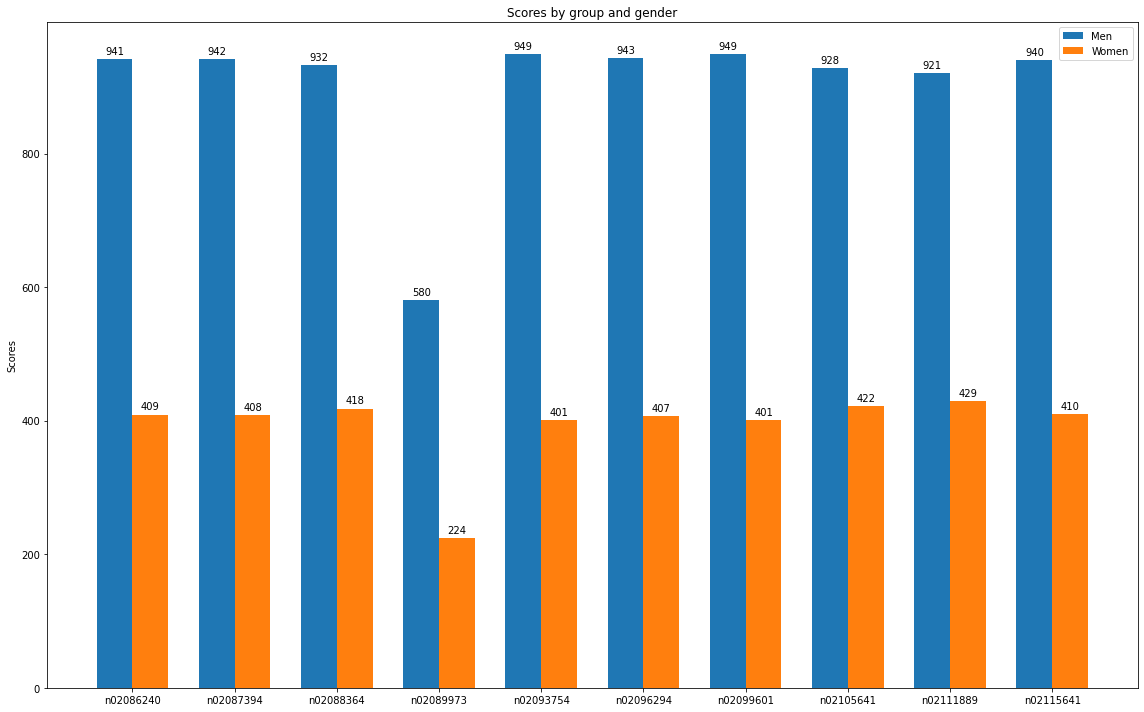

In [9]:
x = np.arange(len(class_cnt_train[0]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 10))
rects1 = ax.bar(x - width/2, class_cnt_train[1], width, label='Men')
rects2 = ax.bar(x + width/2, class_cnt_val[1], width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, class_cnt_train[0])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [10]:
train_data_df

img_path      class
0     data/imagewoof2\train\n02086240\ILSVRC2012_val_00000907.JPEG  n02086240
1     data/imagewoof2\train\n02086240\ILSVRC2012_val_00001244.JPEG  n02086240
2     data/imagewoof2\train\n02086240\ILSVRC2012_val_00001393.JPEG  n02086240
3     data/imagewoof2\train\n02086240\ILSVRC2012_val_00002769.JPEG  n02086240
4     data/imagewoof2\train\n02086240\ILSVRC2012_val_00004049.JPEG  n02086240
...                                                            ...        ...
9020           data/imagewoof2\train\n02115641\n02115641_9824.JPEG  n02115641
9021           data/imagewoof2\train\n02115641\n02115641_9845.JPEG  n02115641
9022           data/imagewoof2\train\n02115641\n02115641_9856.JPEG  n02115641
9023           data/imagewoof2\train\n02115641\n02115641_9977.JPEG  n02115641
9024           data/imagewoof2\train\n02115641\n02115641_9995.JPEG  n02115641

[9025 rows x 2 columns]

In [11]:
def visualize_class(class_name):
    images = train_data_df[train_data_df["class"] == class_name]["img_path"].sample(6)
    i = 1
    fig = plt.figure(figsize = (18, 18))
    plt.suptitle(pseudo2real[class_name], fontsize = '30')
    for image in images:
        img = cv2.imread(image)
        ax = fig.add_subplot(2, 3, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_axis_off()
        i += 1
    plt.show()

In [12]:
train_data_df["class"].unique()

array(['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754',
       'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641'],
      dtype=object)

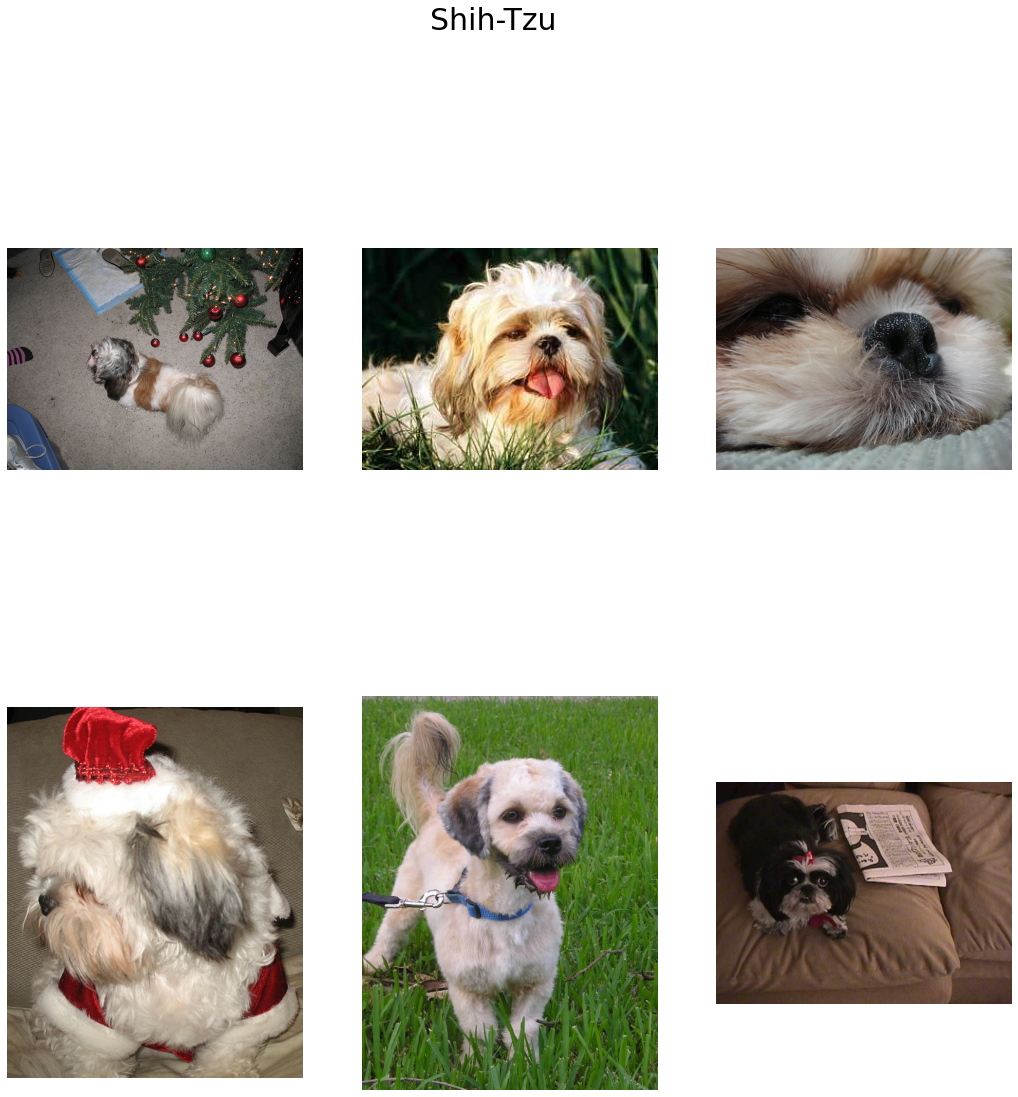

In [13]:
visualize_class("n02086240")

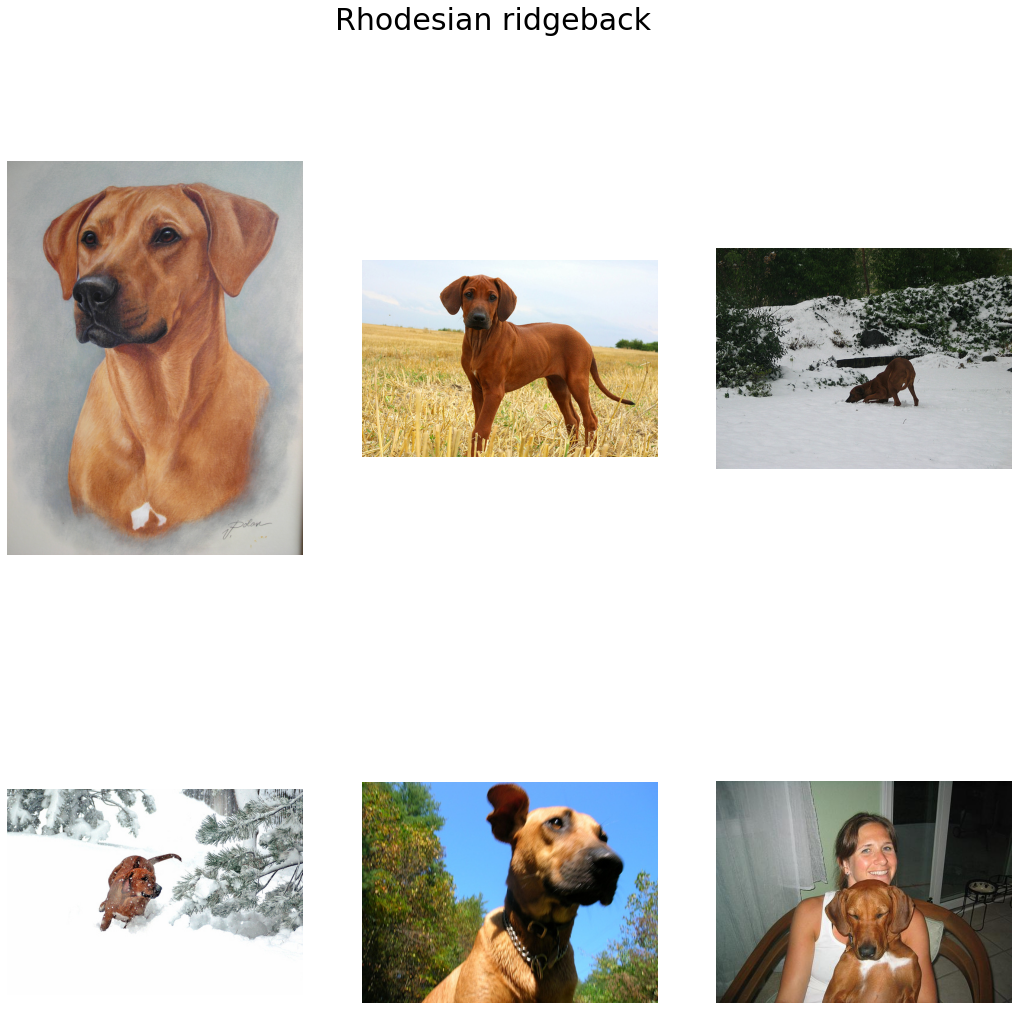

In [14]:
visualize_class("n02087394")

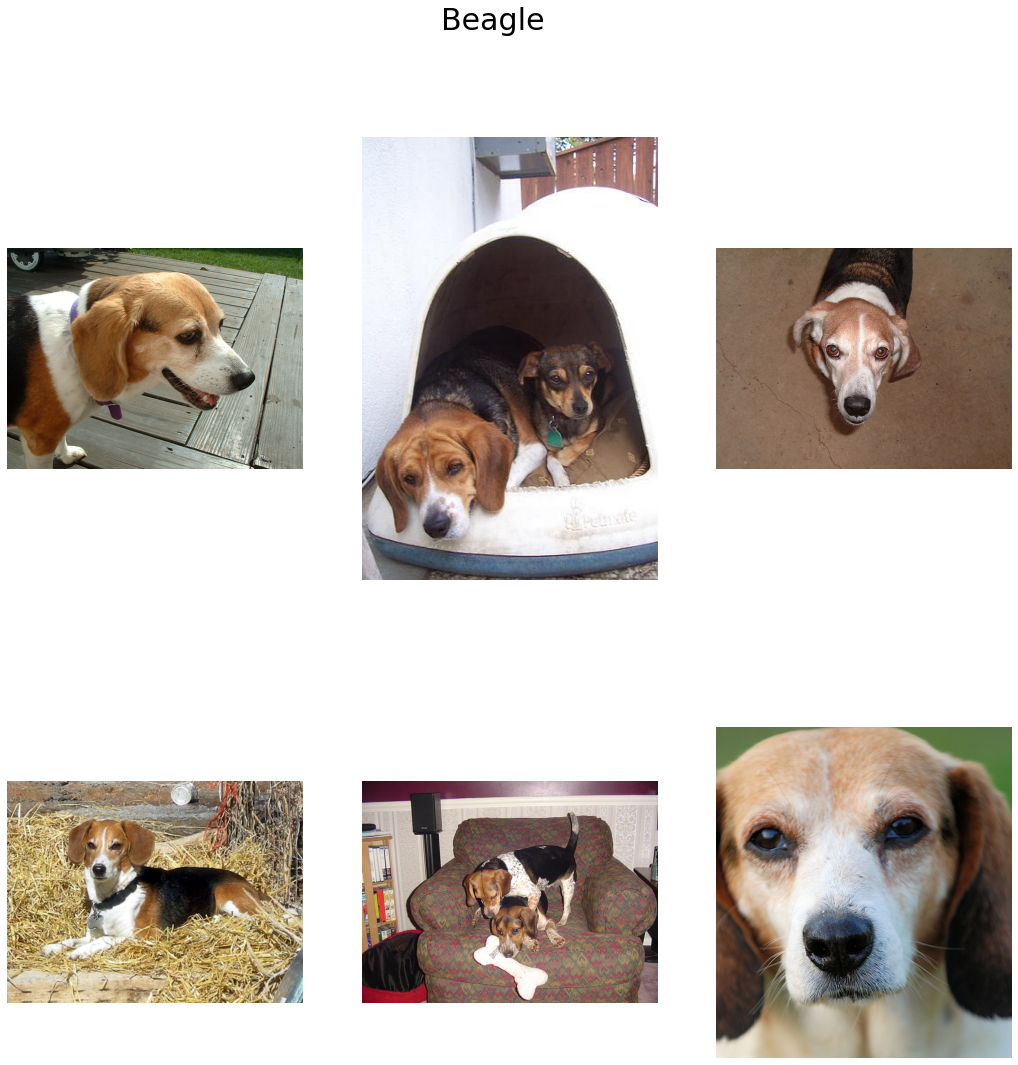

In [15]:
visualize_class("n02088364")

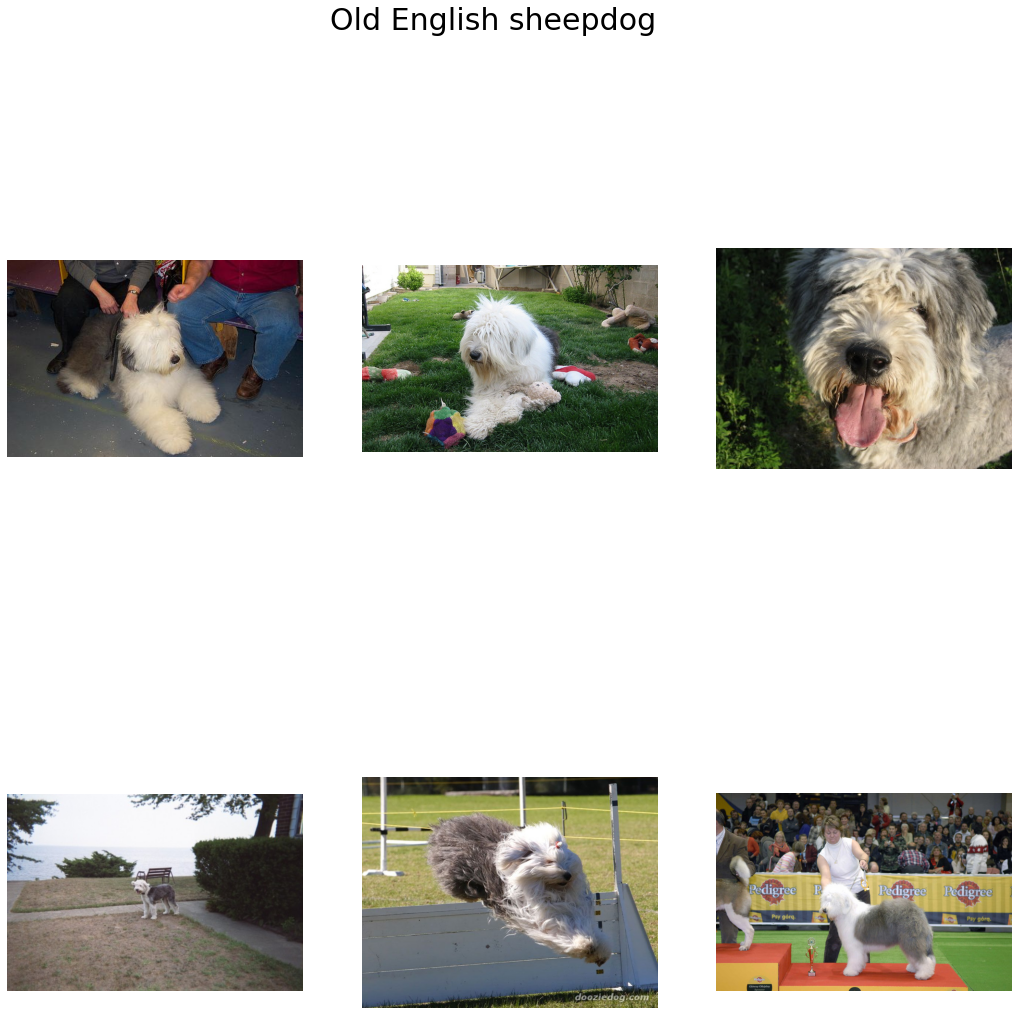

In [16]:
visualize_class("n02105641")

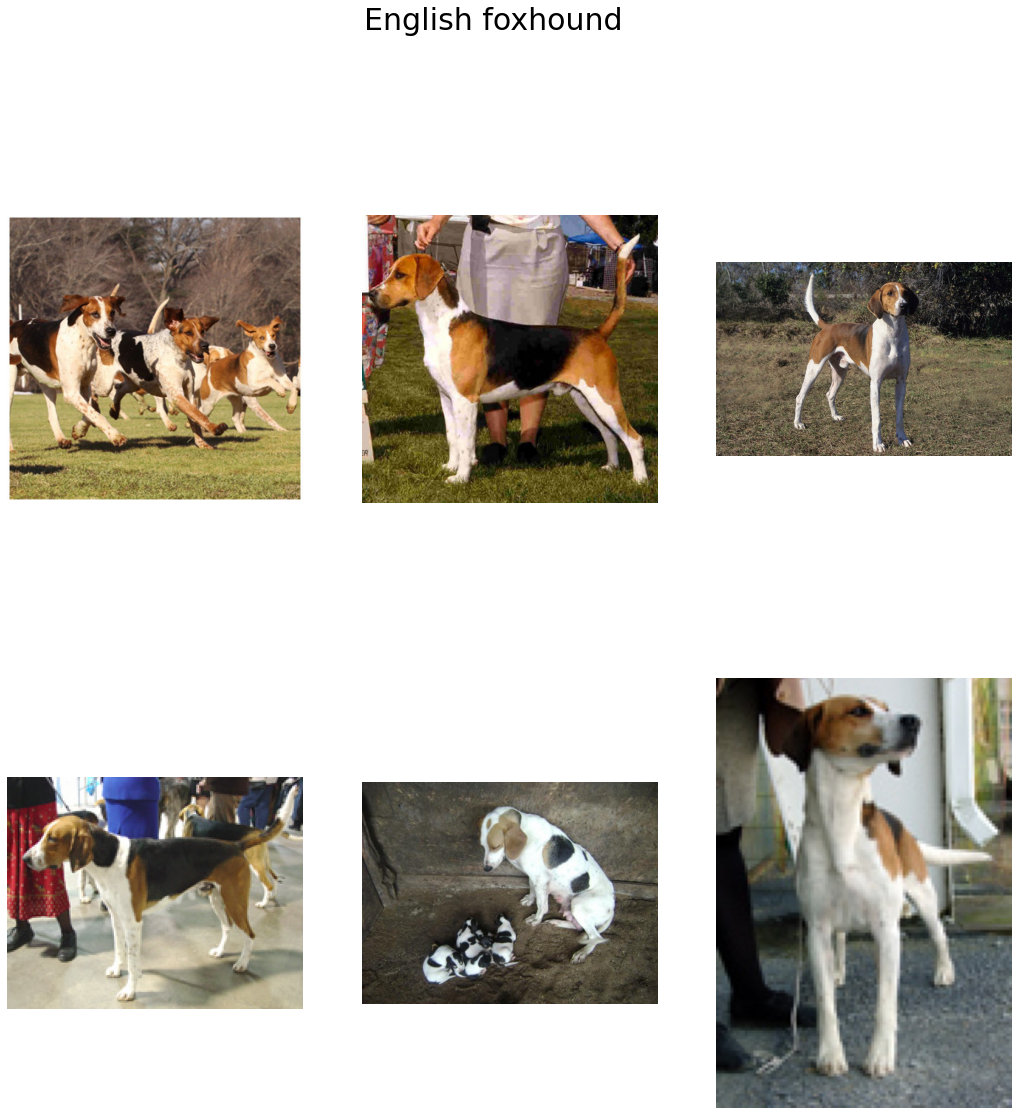

In [17]:
#least popular class
visualize_class("n02089973")

In [18]:
class CONFIG:
    data = 'data/imagewoof2/'
    checkpoint = "weights/Loss1.0944_epoch13.pt"
    batch_size = 3

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
_, val_dl = get_dataloaders(CONFIG)
    
model = get_model()
model.to(device)
    
if CONFIG.checkpoint:
    model.load_state_dict(torch.load(CONFIG.checkpoint))

model.eval()
with torch.no_grad():
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    bar = tqdm(enumerate(val_dl), total=len(val_dl))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))
            
        bar.set_postfix(Accuracy=top1, Accuracy5=top5) 

        torch.cuda.empty_cache()

    gc.collect()

print("Metrics:", top1, top5)

  0%|          | 0/655 [00:00<?, ?it/s]

Metrics: Acc@1  60.00 ( 77.30) Acc@5  60.00 ( 97.20)


In [20]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)
images = inv_normalize(images)

In [21]:
labels, predictions, images = labels.cpu().detach().numpy(), predictions.cpu().detach().numpy(), images.cpu().detach().numpy()
le = LabelEncoder()
le.classes_ = np.load('classes.npy')
labels, predictions = le.inverse_transform(labels), le.inverse_transform(predictions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


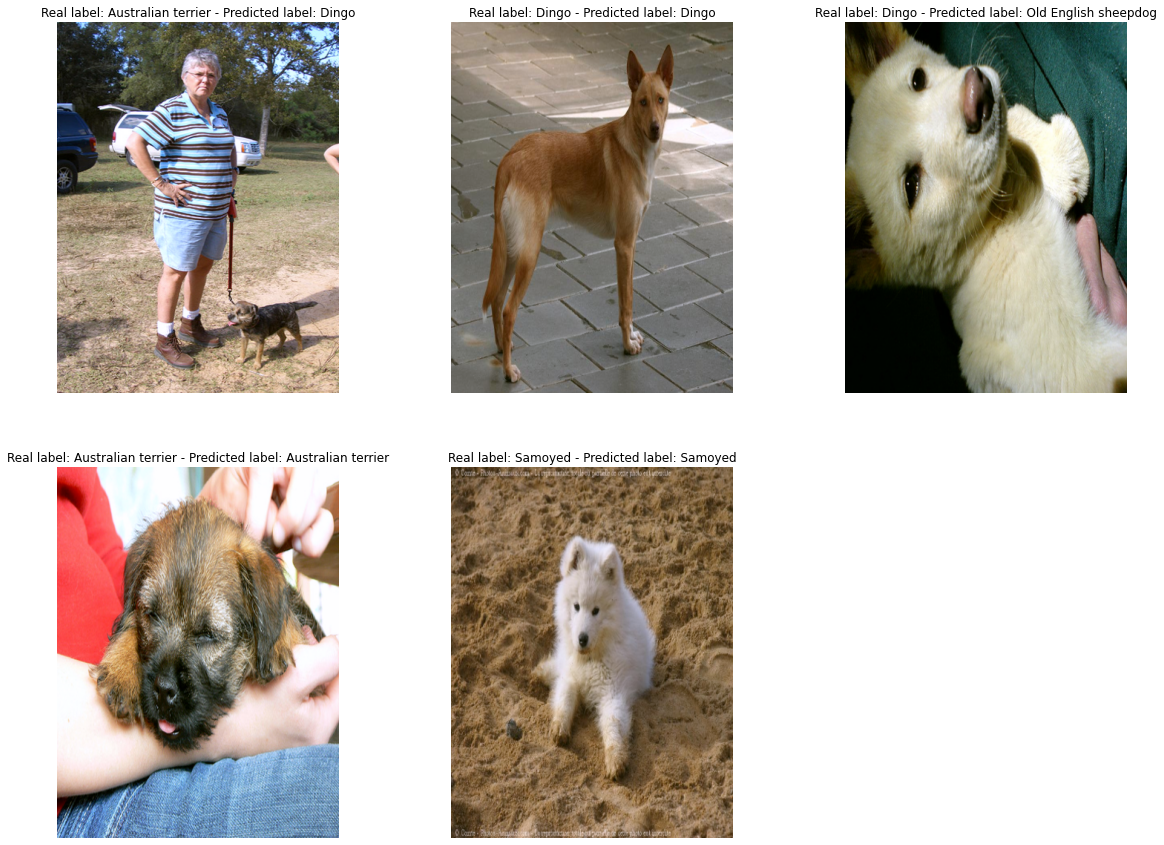

In [22]:
fig = plt.figure(figsize = (20, 15))
i = 1
for l, p, img in zip(labels, predictions, images):
    ax = fig.add_subplot(2, CONFIG.batch_size, i)
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_axis_off()
    ax.title.set_text('Real label: {} - Predicted label: {}'.format(pseudo2real[l], pseudo2real[p]))
    i += 1
plt.show()